In [1]:
import os

import time
from datetime import datetime
from calendar import Calendar

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

%matplotlib inline

/Users/MH/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. TrainingSet

In [4]:
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_CSV_FileName(csvName, FolderName):
    cwd = os.getcwd()
    csvFullName = cwd + '/' + FolderName + '/' + csvName
#     print(csvFullName)
    return csvFullName

def get_TrainingDF(trainDataFrame, trainFeature):
    return trainDataFrame[trainFeature]

def get_PeriodTrainingDF(trainDataFrame):
    trainDataFrame['query_date_month_cos'] = trainDataFrame.eval('cos(query_date_month/12)')
    trainDataFrame['query_date_month_sin'] = trainDataFrame.eval('sin(query_date_month/12)')
    trainDataFrame['query_date_day_cos'] = trainDataFrame.eval('cos(query_date_day/31)')
    trainDataFrame['query_date_day_sin'] = trainDataFrame.eval('sin(query_date_day/31)')
    trainDataFrame['query_date_weekday_cos'] = trainDataFrame.eval('cos(query_date_weekday/7)')
    trainDataFrame['query_date_weekday_sin'] = trainDataFrame.eval('sin(query_date_weekday/7)')
    return trainDataFrame

def get_NormalizedTrainingDF(trainDataFrame):
    try:
        trainDataFrame['query_date_month'] = trainDataFrame['query_date_month']/12
        trainDataFrame['query_date_day'] = trainDataFrame['query_date_day']/31
        trainDataFrame['query_date_weekday'] = trainDataFrame['query_date_weekday']/7
    except:
        print("Unexpected error:", sys.exc_info())
    return trainDataFrame

In [12]:
UserName = 'mPOS'
# UserName = 'CSIS-SIT3'
# UserName = 'user1'
# UserName = 'user4'

TrainingDataFolder = 'TrainingDataSets/' + UserName + '/'
csvTrainingFile = get_CSV_FileName('TrainingFeature.csv', TrainingDataFolder)

check_file_path_exist(csvTrainingFile)

trainDF = pd.read_csv(csvTrainingFile, index_col=False )
feature = [  'query_date_year' , 'query_date_month'  ,'query_date_day', 'query_date_weekday'  ]
data = pd.get_dummies(get_TrainingDF(trainDF,feature))
data = get_PeriodTrainingDF(data)
data = get_NormalizedTrainingDF(data)

docDF = pd.read_csv(csvTrainingFile, index_col=False)['doc'].value_counts(0)
docDFHead = docDF.axes[0]

In [13]:
# data['query_date_month_cos'] = data.eval('cos(query_date_month/12)')
# data['query_date_month_sin'] = data.eval('sin(query_date_month/12)')
# data['query_date_day_cos'] = data.eval('cos(query_date_day/31)')
# data['query_date_day_sin'] = data.eval('sin(query_date_day/31)')
# data['query_date_weekday_cos'] = data.eval('cos(query_date_weekday/7)')
# data['query_date_weekday_cos'] = data.eval('sin(query_date_weekday/7)')

In [14]:
data.describe()

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
count,1962.0,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000
mean,2017.0,0.251572,0.502894,0.487549,0.966857,0.248499,0.849592,0.467030,0.863752,0.458281
std,0.0,0.058679,0.248437,0.211532,0.014643,0.056779,0.123132,0.212002,0.096392,0.186124
min,2017.0,0.166667,0.032258,0.142857,0.944957,0.165896,0.540302,0.032252,0.654600,0.142372
25%,2017.0,0.250000,0.290323,0.285714,0.944957,0.247404,0.779193,0.286261,0.755561,0.281843
50%,2017.0,0.250000,0.516129,0.571429,0.968912,0.247404,0.869736,0.493517,0.841129,0.540834
75%,2017.0,0.333333,0.677419,0.714286,0.968912,0.327195,0.958152,0.626784,0.959461,0.655078
max,2017.0,0.333333,1.000000,0.857143,0.986143,0.327195,0.999480,0.841471,0.989813,0.755975


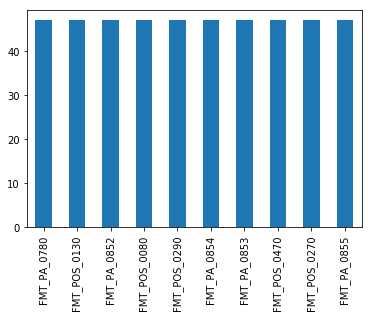

In [15]:
plt.figure();
docDF[:10].plot(kind='bar')

In [16]:
docDF[:5]

FMT_PA_0780     47
FMT_POS_0130    47
FMT_PA_0852     47
FMT_POS_0080    47
FMT_POS_0290    47
Name: doc, dtype: int64

## 2. Target Set

In [17]:
def get_TargetDF(targetDoc, targetDocFolder):
    csvTargetFileName = '_Target.csv'
    csvTargetFile = get_CSV_FileName(targetDoc + csvTargetFileName, targetDocFolder)
    targetDF = pd.read_csv(csvTargetFile, index_col=False )
    target = get_TrainingDF(targetDF, targetDoc)
    return target

In [18]:
targetDoc = 'FMT_POS_190'
target = get_TargetDF(targetDoc, TrainingDataFolder)

## 3. Check DataSets

In [19]:
def get_TrainingDataShape(trainDataFrame, targetingDataFrame):
    print('Fearture Data Size (X): ', trainDataFrame.shape, ', Target Data Size (Y): ', targetingDataFrame.shape)

In [20]:
get_TrainingDataShape(data, target)

Fearture Data Size (X):  (1962, 10) , Target Data Size (Y):  (1962,)


In [21]:
data.head(5)

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
0,2017,0.166667,0.258065,0.428571,0.986143,0.165896,0.966886,0.25521,0.90956,0.415572
1,2017,0.166667,0.258065,0.428571,0.986143,0.165896,0.966886,0.25521,0.90956,0.415572
2,2017,0.166667,0.258065,0.428571,0.986143,0.165896,0.966886,0.25521,0.90956,0.415572
3,2017,0.166667,0.258065,0.428571,0.986143,0.165896,0.966886,0.25521,0.90956,0.415572
4,2017,0.166667,0.258065,0.428571,0.986143,0.165896,0.966886,0.25521,0.90956,0.415572


In [22]:
featureHead = data.axes[1]
print(featureHead)

Index(['query_date_year', 'query_date_month', 'query_date_day',
       'query_date_weekday', 'query_date_month_cos', 'query_date_month_sin',
       'query_date_day_cos', 'query_date_day_sin', 'query_date_weekday_cos',
       'query_date_weekday_sin'],
      dtype='object')


## 4. Classify model

In [82]:
def set_Training_RandomForest(trainDataFrame, targetingDataFrame):
    X_train, X_test, y_train, y_test = train_test_split(trainDataFrame, targetingDataFrame, test_size=0.30, random_state=30)
#     print('Training Data Size: ')
#     get_TrainingDataShape(X_train, y_train)
#     print('Test Data Size: ')
#     get_TrainingDataShape(X_test, y_test)
    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    print('Test Model Score: ',model.score(X_test, y_test) )
    print('Model Parameter: ',model.get_params )
#     print('Cross Validation Score', np.mean(cross_val_score(model, X_train, y_train, cv=10)))
    print("Click Rate: ",target.sum()/len(target)*100, "%")
    return model

def set_Training_LogisticRegression(trainDataFrame, targetingDataFrame):
    X_train, X_test, y_train, y_test = train_test_split(trainDataFrame, targetingDataFrame, test_size=0.30, random_state=30)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    print('Test Model Score: ',model.score(X_test, y_test) )
    print('Model Parameter: ',model.get_params )
#     print('Cross Validation Score', np.mean(cross_val_score(model, X_train, y_train, cv=10)))
    print("Click Rate: ",target.sum()/len(target)*100, "%")
    return model


def get_Date_YearMonthDay(target_year, target_month):
    month = Calendar().itermonthdates(target_year,target_month)
    allday =[day for day in month if day.month == target_month]
    return allday

def get_PredictInput(predicDate):
#     input normalized predict input
    year  = predicDate.year
    month = predicDate.month/12
    day = predicDate.day/31
    weekday = (predicDate.weekday()+1)/7
    PredictInput = [year, month, day, weekday, math.cos(month),math.sin(month),math.cos(day), \
                    math.sin(day),math.cos(weekday),math.sin(weekday)]
    return PredictInput

In [83]:
model_RandomForest  = set_Training_RandomForest(data, target)
model_LogisticRegression = set_Training_LogisticRegression(data, target)

Test Model Score:  0.986417657046
Model Parameter:  <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>
Click Rate:  1.42711518858 %
Test Model Score:  0.986417657046
Model Parameter:  <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
Click Rate:  1.42711518858 %


## feature selection importance

Feature ranking:
1. feature 2 - query_date_day (0.234592)
2. feature 7 - query_date_day_sin (0.225157)
3. feature 6 - query_date_day_cos (0.217232)
4. feature 9 - query_date_weekday_sin (0.063851)
5. feature 8 - query_date_weekday_cos (0.058059)
6. feature 3 - query_date_weekday (0.056335)
7. feature 4 - query_date_month_cos (0.050850)
8. feature 5 - query_date_month_sin (0.047632)
9. feature 1 - query_date_month (0.046291)
10. feature 0 - query_date_year (0.000000)


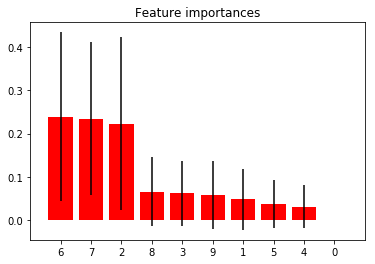

In [86]:
def get_FeatureImportance(model,featureName):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(len(featureName)):
        print("%d. feature %d - %s (%f)" % (f + 1, indices[f], featureName[indices[f]], importances[indices[f]]))
        
def get_FeatureImportance_Boxplot(model, featureName):
    featureLenght = len(featureName)
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(featureLenght), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(featureLenght), indices)
    plt.xlim([-1, featureLenght])
    plt.show()


get_FeatureImportance(model_RandomForest,featureHead)
get_FeatureImportance_Boxplot(model_RandomForest,featureHead)

In [227]:
data.head(5)

,query_date_year,query_date_month,query_date_day,query_date_weekday,query_date_month_cos,query_date_month_sin,query_date_day_cos,query_date_day_sin,query_date_weekday_cos,query_date_weekday_sin
0,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
1,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
2,2017,0.166667,0.483871,0.428571,0.986143,0.165896,0.885201,0.465209,0.909560,0.415572
3,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078
4,2017,0.166667,0.548387,0.714286,0.986143,0.165896,0.853366,0.521312,0.755561,0.655078


In [87]:
allday = get_Date_YearMonthDay(2017,5)
PredictInput = get_PredictInput(allday[0])
print("PredictInput: ",PredictInput)

PredictInput:  [2017, 0.4166666666666667, 0.03225806451612903, 0.14285714285714285, 0.9144430665938302, 0.40471456356112473, 0.9994797537524555, 0.032252470276413724, 0.9898132604466151, 0.14237172979226365]


In [96]:
def get_PredictResult(predictModel,targetDoc, ClickDoc_Prob = .05):
    print("Predic Doc Name: " + targetDoc )
    predict_history = []
    for predic_month in range(12):
        allday = get_Date_YearMonthDay(2017,predic_month+1)
        for day in allday:
            PredictInput = get_PredictInput(day)
            doc_predict = predictModel.predict([PredictInput])
            doc_predict_proba = predictModel.predict_proba([PredictInput])
#             print(doc_predict_proba)
            if (len(doc_predict_proba[0]) > 1):
                if (doc_predict_proba[0][1] >= ClickDoc_Prob):
                    predict_history.append([targetDoc,day.strftime('%m/%d/%Y'),day.weekday()+1,doc_predict_proba[0][1]])
#                     print(day," weekday: ", day.weekday()+1)
#                     print("user feature: ", ('doc_' + targetDoc), " click prob: ", doc_predict_proba) 
    return predict_history

In [97]:
getpredic = get_PredictResult(model_RandomForest, targetDoc)
getpredic[:5]

Predic Doc Name: FMT_POS_190


[['FMT_POS_190', '01/12/2017', 4, 0.055557475270694025],
 ['FMT_POS_190', '02/12/2017', 7, 0.051265251401332222],
 ['FMT_POS_190', '04/12/2017', 3, 0.11211027710673782],
 ['FMT_POS_190', '05/12/2017', 5, 0.084214479491667743],
 ['FMT_POS_190', '06/12/2017', 1, 0.08042602049571318]]

In [91]:
doc_predict_proba = model.predict_proba([PredictInput])
len(doc_predict_proba[0])
docDFHead[:5]

Index(['FMT_PA_0780', 'FMT_POS_0130', 'FMT_PA_0852', 'FMT_POS_0080',
       'FMT_POS_0290'],
      dtype='object')

In [237]:
# 1
# UserName = 'mPOS'
# UserName = 'CSIS-SIT3'
UserName = 'user1'
# UserName = 'user4'

TrainingDataFolder = 'TrainingDataSets/' + UserName + '/'
csvTrainingFile = get_CSV_FileName('TrainingFeature.csv', TrainingDataFolder)

trainDF = pd.read_csv(csvTrainingFile, index_col=False )
feature = [  'query_date_year' , 'query_date_month'  ,'query_date_day', 'query_date_weekday'  ]
data = pd.get_dummies(get_TrainingDF(trainDF,feature))
data = get_PeriodTrainingDF(data)
data = get_NormalizedTrainingDF(data)

docDFHead = pd.read_csv(csvTrainingFile, index_col=False)['doc'].value_counts(0).axes[0]
clickDocPrediction = []

for idx, targetDoc in enumerate(docDFHead):
    if(idx%10==0):
        print("Processing: {0:.2f}%".format(idx*100/len(docDFHead)))

    target = get_TargetDF(targetDoc, TrainingDataFolder)
    model  = set_Training_RandomForest(data, target)
    predictEachDoc = get_PredictResult(model_RandomForest, targetDoc)
    if (len(predictEachDoc)> 0):
        clickDocPrediction.extend(predictEachDoc)
    elif (len(predictEachDoc) == 0):
        print(targetDoc, "No click in prediction")

Processing: 0.00%
Test Model Score:  0.934579439252
Click Rate:  6.47887323944 %
Predic Doc Name: #POLICY#
Test Model Score:  0.96261682243
Click Rate:  5.35211267606 %
Predic Doc Name: ODS_FIN_0860
Test Model Score:  0.934579439252
Click Rate:  3.94366197183 %
Predic Doc Name: ODS_FIN_0770
Test Model Score:  0.981308411215
Click Rate:  2.81690140845 %
Predic Doc Name: ODS_FIN_0730
Test Model Score:  0.943925233645
Click Rate:  2.81690140845 %
Predic Doc Name: FMT_POS_0250
Test Model Score:  0.981308411215
Click Rate:  2.25352112676 %
Predic Doc Name: ODS_FIN_0830
Test Model Score:  0.96261682243
Click Rate:  2.25352112676 %
Predic Doc Name: ODS_FIN_1340
Test Model Score:  0.990654205607
Click Rate:  1.97183098592 %
Predic Doc Name: FMT_PA_0850
Test Model Score:  0.971962616822
Click Rate:  1.69014084507 %
Predic Doc Name: FMT_POS_0380
Test Model Score:  0.981308411215
Click Rate:  1.69014084507 %
Predic Doc Name: ODS_FIN_0810
Processing: 7.41%
Test Model Score:  1.0
Click Rate:  1.408

In [238]:
predicDF = pd.DataFrame(clickDocPrediction, columns=['doc', 'query_date', 'query_date_weekday', 'click rate'])
predicDF = predicDF.sort_values(by=['query_date'])

TrainingDataFolder = 'PredictionResult'
csvPreditionFile = get_CSV_FileName(UserName + '_PredictDoc_10_Feature.csv', TrainingDataFolder)
check_file_path_exist(csvPreditionFile)

predicDF.to_csv(csvPreditionFile)

In [239]:
predicDF.head(5)

,doc,query_date,query_date_weekday,click rate
0,#POLICY#,01/01/2017,7,0.142504
2197,ODS_POS_1340,01/01/2017,7,0.229524
2046,ODS_POS_7030,01/01/2017,7,0.074395
2012,ODS_POS_1250,01/01/2017,7,0.129505
467,ODS_FIN_0730,01/01/2017,7,0.059444
